In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
from geopy.distance import geodesic 

In [5]:
def load_bridge_data(csv_file_path):
    """Load bridge sensor data from CSV file"""
    df = pd.read_csv(csv_file_path)
    return df

In [6]:
def calculate_3d_distance(coord1, coord2):
    """Calculate 3D distance considering lat, lon, and altitude"""

    horizontal_dist = geodesic((coord1[0], coord1[1]), (coord2[0], coord2[1])).meters
    

    vertical_dist = abs(coord1[2] - coord2[2])
    

    distance_3d = np.sqrt(horizontal_dist**2 + vertical_dist**2)
    
    return distance_3d

In [7]:
def get_stiffness_value(src_type, tgt_type, distance_m):
    """
    Get stiffness value based on structural element types and distance
    pier: 1.2, girder: 1.0, pylon: 1.5, ground: 0.8
    """

    type_stiffness = {
        'pier': 1.2,
        'girder': 1.0, 
        'pylon': 1.5,
        'ground': 0.8
    }
    

    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.1  
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        return 1.3  
    

    if src_type == tgt_type:
        base_stiffness = type_stiffness.get(src_type, 1.0)
      
        distance_factor = max(0.5, 1.0 - (distance_m / 500.0))
        return round(base_stiffness * distance_factor, 2)
    

    src_stiff = type_stiffness.get(src_type, 1.0)
    tgt_stiff = type_stiffness.get(tgt_type, 1.0)
    return round((src_stiff + tgt_stiff) / 2, 2)


In [8]:
def is_valid_connection(src_type, tgt_type, distance_m, k_value):
    """
    Determine if a connection is structurally valid based on type filtering
    More restrictive for k=3,4 to prevent unrealistic long-distance connections
    """
    # For k=2, allow all connections (original behavior)
    if k_value == 2:
        return True
    
    # Define maximum reasonable distances for different connection types
    max_distances = {
        # Same-type connections (sensors on same structural element)
        ('girder', 'girder'): 150.0,  # Girders can be connected along bridge length
        ('pier', 'pier'): 200.0,      # Piers can be far apart
        ('ground', 'ground'): 300.0,  # Ground sensors can be widely spaced
        ('pylon', 'pylon'): 400.0,    # Pylons are typically far apart
        
        # Cross-type connections (structural connections)
        ('pier', 'girder'): 50.0,     # Pier directly supports girder - short distance
        ('girder', 'pier'): 50.0,     # Same as above
        ('pylon', 'girder'): 80.0,    # Pylon supports girder via cables
        ('girder', 'pylon'): 80.0,    # Same as above
        ('ground', 'pier'): 20.0,     # Ground sensor near pier foundation
        ('pier', 'ground'): 20.0,     # Same as above
        ('ground', 'girder'): 100.0,  # Ground sensor monitoring girder from below
        ('girder', 'ground'): 100.0,  # Same as above
        ('ground', 'pylon'): 30.0,    # Ground sensor near pylon foundation
        ('pylon', 'ground'): 30.0,    # Same as above
    }
    
    # Get maximum allowed distance for this connection type
    connection_key = (src_type, tgt_type)
    max_dist = max_distances.get(connection_key, 200.0)  # Default fallback
    
    return distance_m <= max_dist

In [17]:
def get_improved_stiffness_value(src_type, tgt_type, distance_m, k_value):
    """
    Improved stiffness calculation with better structural engineering principles
    """

    if k_value == 2:
        return get_stiffness_value(src_type, tgt_type, distance_m)
    

    base_stiffness = {
        'pier': 1.4,      # Increased - piers are very stiff
        'girder': 1.0,    # Reference value
        'pylon': 1.8,     # Increased - pylons are extremely stiff
        'ground': 0.6     # Decreased - ground has lower stiffness
    }
    
    # Critical structural connections with higher stiffness
    if ('pier' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        # Pier-girder: critical load transfer connection
        base_value = 1.4
        # Higher stiffness for closer connections
        distance_factor = max(0.7, 1.2 - (distance_m / 100.0))
        return round(base_value * distance_factor, 2)
    
    elif ('pylon' in [src_type, tgt_type]) and ('girder' in [src_type, tgt_type]):
        # Pylon-girder: main cable support connection
        base_value = 1.6
        distance_factor = max(0.8, 1.3 - (distance_m / 150.0))
        return round(base_value * distance_factor, 2)
    
    elif ('ground' in [src_type, tgt_type]) and (src_type != tgt_type):
        # Ground connections: foundation monitoring
        return 0.7  # Lower stiffness for ground connections
    
    # Same-type connections
    elif src_type == tgt_type:
        base_value = base_stiffness.get(src_type, 1.0)
        
        if src_type == 'girder':
            # Girder-girder: continuous beam behavior
            distance_factor = max(0.6, 1.1 - (distance_m / 200.0))
        elif src_type == 'pier':
            # Pier-pier: independent support elements
            distance_factor = max(0.5, 1.0 - (distance_m / 300.0))
        else:
            # Other same-type connections
            distance_factor = max(0.5, 1.0 - (distance_m / 250.0))
        
        return round(base_value * distance_factor, 2)
    
    # Other mixed connections
    else:
        src_stiff = base_stiffness.get(src_type, 1.0)
        tgt_stiff = base_stiffness.get(tgt_type, 1.0)
        base_value = (src_stiff + tgt_stiff) / 2
        distance_factor = max(0.6, 1.0 - (distance_m / 200.0))
        return round(base_value * distance_factor, 2)

In [18]:
def create_knn_edges(df, k=3):
    """Create edges using K-Nearest Neighbors algorithm with proper 3D distances and type filtering"""
    # Extract coordinates (lat, lon, altitude)
    coords = df[['latitude', 'longitude', 'altitude_m']].values
    node_ids = df['node_id'].tolist()
    
    print(f"\nAnalyzing sensor positions:")
    girder_alts = df[df['type']=='girder']['altitude_m'].values
    pier_alts = df[df['type']=='pier']['altitude_m'].values
    ground_alts = df[df['type']=='ground']['altitude_m'].values
    
    print(f"Girder sensors altitude range: {min(girder_alts):.1f}m - {max(girder_alts):.1f}m")
    print(f"Pier sensors altitude range: {min(pier_alts):.1f}m - {max(pier_alts):.1f}m") 
    print(f"Ground sensors altitude: {ground_alts[0]:.1f}m")
    print(f"Typical girder-pier height difference: {np.mean(girder_alts) - np.mean(pier_alts):.1f}m")
    

    n_nodes = len(df)
    distances_matrix = np.zeros((n_nodes, n_nodes))
    
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                dist = calculate_3d_distance(coords[i], coords[j])
                distances_matrix[i][j] = dist
    

    edge_info = []
    edges_set = set()
    
    print(f"\nApplying type filtering for k={k}:")
    print("- Pier-girder connections limited to 50m (direct support)")
    print("- Ground-pier connections limited to 20m (foundation)")
    print("- Girder-girder connections limited to 150m (continuous beam)")
    
    for i in range(n_nodes):
        src_id = node_ids[i]
        src_type = df.iloc[i]['type']
        

        valid_neighbors = []
        for j in range(n_nodes):
            if i != j:
                tgt_type = df.iloc[j]['type']
                distance = distances_matrix[i][j]
                
                if is_valid_connection(src_type, tgt_type, distance, k):
                    valid_neighbors.append((j, distance))
        
    
        valid_neighbors.sort(key=lambda x: x[1])
        selected_neighbors = valid_neighbors[:k]
        
        print(f"\nNode {src_id} ({src_type}) connects to:")
        rejected_count = len([j for j in range(n_nodes) if i != j]) - 1 - len(valid_neighbors)
        if rejected_count > 0 and k > 2:
            print(f"  (Rejected {rejected_count} connections due to type filtering)")
        
        for idx, (j, distance) in enumerate(selected_neighbors):
            tgt_id = node_ids[j]
            tgt_type = df.iloc[j]['type']
            print(f"  {idx+1}. {tgt_id} ({tgt_type}) - {distance:.1f}m")
        
        for j, distance in selected_neighbors:
            tgt_id = node_ids[j]
            tgt_type = df.iloc[j]['type']
            

            edge = tuple(sorted((src_id, tgt_id)))
            if edge not in edges_set:
                edges_set.add(edge)
                
                # Determine edge type
                if src_type == tgt_type:
                    edge_type = src_type
                else:
                    edge_type = "support" 
                
                # Get improved stiffness value
                stiffness = get_improved_stiffness_value(src_type, tgt_type, distance, k)
                
                edge_info.append({
                    'source': edge[0],
                    'target': edge[1],
                    'type': edge_type,
                    'stiffness': stiffness,
                    'distance_m': round(distance, 2),
                    'src_type': src_type,
                    'tgt_type': tgt_type
                })
    
    return edge_info

In [10]:
def analyze_connections(df, edges, k_value):
    """Analyze the types of connections created"""
    print(f"\n=== Connection Analysis (k={k_value}) ===")
    
 
    connection_counts = {}
    for edge in edges:
        edge_type = edge['type']
        connection_counts[edge_type] = connection_counts.get(edge_type, 0) + 1
    
    print("Connection types:")
    for conn_type, count in sorted(connection_counts.items()):
        avg_stiffness = np.mean([e['stiffness'] for e in edges if e['type'] == conn_type])
        avg_distance = np.mean([e['distance_m'] for e in edges if e['type'] == conn_type])
        print(f"  {conn_type}: {count} edges (avg stiffness: {avg_stiffness:.2f}, avg distance: {avg_distance:.1f}m)")
    

    support_connections = [e for e in edges if e['type'] == 'support']
    print(f"\nStructural connections:")
    print(f"  Support connections (cross-type): {len(support_connections)}")
    
    # Analyze critical connections for k>=3
    if k_value >= 3:
        pier_girder = [e for e in support_connections if 
                      ('pier' in [e['src_type'], e['tgt_type']]) and 
                      ('girder' in [e['src_type'], e['tgt_type']])]
        pylon_girder = [e for e in support_connections if 
                       ('pylon' in [e['src_type'], e['tgt_type']]) and 
                       ('girder' in [e['src_type'], e['tgt_type']])]
        
        print(f"  Pier-girder connections: {len(pier_girder)} (critical load transfer)")
        print(f"  Pylon-girder connections: {len(pylon_girder)} (main cable support)")
        
        if pier_girder:
            avg_pier_girder_stiffness = np.mean([e['stiffness'] for e in pier_girder])
            avg_pier_girder_dist = np.mean([e['distance_m'] for e in pier_girder])
            print(f"    Pier-girder avg: {avg_pier_girder_stiffness:.2f} stiffness, {avg_pier_girder_dist:.1f}m distance")
    
    if support_connections:
        print("  Examples of support connections:")
        for conn in support_connections[:8]:  # Show first 8
            print(f"    {conn['source']} ({conn['src_type']}) ↔ {conn['target']} ({conn['tgt_type']}) - {conn['distance_m']:.1f}m, stiffness={conn['stiffness']}")

In [11]:
def save_edges_csv(edges, filename='bridge_edges.csv'):
    """Save edges to CSV file"""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['source', 'target', 'type', 'stiffness', 'distance_m', 'src_type', 'tgt_type'])
        for edge in edges:
            writer.writerow([edge['source'], edge['target'], edge['type'], 
                           edge['stiffness'], edge['distance_m'], edge['src_type'], edge['tgt_type']])
    print(f"Edges saved to {filename}")

In [12]:
def create_networkx_graph(df, edges):
    """Create NetworkX graph from nodes and edges"""
    G = nx.Graph()
    

    for _, row in df.iterrows():
        G.add_node(row['node_id'], 
                  type=row['type'],
                  pos=(row['longitude'], row['latitude']),
                  altitude=row['altitude_m'])
    

    for edge in edges:
        G.add_edge(edge['source'], edge['target'],
                  type=edge['type'],
                  stiffness=edge['stiffness'],
                  distance_m=edge['distance_m'])
    
    return G

In [13]:
def visualize_bridge_network(G, df, k_value=3):
    """Create 2D and 3D visualizations of the bridge network"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 2D Plot
    pos = nx.get_node_attributes(G, 'pos')
    
    # Color nodes by type
    node_colors = []
    color_map = {'girder': 'yellow', 'pier': 'cyan', 'ground': 'green', 'pylon': 'red'}
    for node in G.nodes():
        node_colors.append(color_map[G.nodes[node]['type']])
    
    # Color edges by type with emphasis on structural connections
    edge_colors = []
    edge_color_map = {
        'girder': 'blue',
        'pier': 'purple', 
        'ground': 'brown',
        'support': 'red',      # All cross-type connections (most important)
    }
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        edge_colors.append(edge_color_map.get(edge_type, 'gray'))
    
    # Draw network with edge thickness based on stiffness (enhanced for k>=3)
    edge_widths = []
    for edge in G.edges():
        stiffness = G.edges[edge]['stiffness']
        if k_value >= 3:
            # Enhanced visualization for improved stiffness values
            edge_widths.append(stiffness * 2.0)
        else:
            edge_widths.append(stiffness * 1.5)
    
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=node_colors, 
            edge_color=edge_colors, node_size=400, font_size=9, font_weight='bold', width=edge_widths)
    
    title_suffix = " (Type Filtered)" if k_value >= 3 else ""
    ax1.set_title(f'Bridge Sensor Network (2D) - K={k_value}{title_suffix}\nEdge width=stiffness, Red=support connections')
    
    # Create legend for nodes
    node_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in color_map.values()]
    ax1.legend(node_legend, list(color_map.keys()), loc='upper left', title='Nodes')
    
    # 3D Plot
    ax3d = fig.add_subplot(122, projection='3d')
    
    # Plot nodes in 3D
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        z = G.nodes[node]['altitude']
        color = color_map[G.nodes[node]['type']]
        ax3d.scatter(x, y, z, c=color, s=150)
        ax3d.text(x, y, z + 1, str(node), fontsize=8)
    
    # Draw edges in 3D with enhanced visualization for k>=3
    for edge in G.edges():
        x_coords = [G.nodes[edge[0]]['pos'][0], G.nodes[edge[1]]['pos'][0]]
        y_coords = [G.nodes[edge[0]]['pos'][1], G.nodes[edge[1]]['pos'][1]]
        z_coords = [G.nodes[edge[0]]['altitude'], G.nodes[edge[1]]['altitude']]
        
        # Color edges based on type
        edge_type = G.edges[edge]['type']
        edge_color = edge_color_map.get(edge_type, 'gray')
        stiffness = G.edges[edge]['stiffness']
        
        # Enhanced linewidth for k>=3
        if k_value >= 3:
            linewidth = stiffness * 2.0
            alpha = 0.9 if edge_type == 'support' else 0.7
        else:
            linewidth = stiffness * 1.5
            alpha = 0.8
            
        ax3d.plot(x_coords, y_coords, z_coords, color=edge_color, 
                 alpha=alpha, linewidth=linewidth)
    
    ax3d.set_xlabel('Longitude')
    ax3d.set_ylabel('Latitude')
    ax3d.set_zlabel('Altitude (m)')
    ax3d.set_title(f'Bridge Sensor Network (3D) - K={k_value}{title_suffix}\nRed=support, Thick=high stiffness')
    
    # Set proper aspect ratio for bridge visualization
    ax3d.set_box_aspect([4,2,1])  # Bridge is long and relatively flat
    
    plt.tight_layout()
    plt.show()

In [15]:
def analyze_graph_properties(G, k_value):
    """Analyze and print graph properties"""
    print(f"=== Graph Network Analysis (k={k_value}) ===")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G):.3f}")
    print(f"Is connected: {nx.is_connected(G)}")
    
 
    node_types = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print("\nNode type distribution:")
    for node_type, count in node_types.items():
        print(f"  {node_type}: {count}")
    
 
    edge_types = {}
    stiffness_stats = {}
    
    for edge in G.edges():
        edge_type = G.edges[edge]['type']
        stiffness = G.edges[edge]['stiffness']
        
        edge_types[edge_type] = edge_types.get(edge_type, 0) + 1
        
        if edge_type not in stiffness_stats:
            stiffness_stats[edge_type] = []
        stiffness_stats[edge_type].append(stiffness)
    
    print("\nEdge type distribution:")
    for edge_type, count in edge_types.items():
        avg_stiffness = np.mean(stiffness_stats[edge_type])
        max_stiffness = np.max(stiffness_stats[edge_type])
        min_stiffness = np.min(stiffness_stats[edge_type])
        print(f"  {edge_type}: {count} edges (stiffness: avg={avg_stiffness:.2f}, range={min_stiffness:.2f}-{max_stiffness:.2f})")

=== Improved Shin-Nakagawa Bridge Sensor Network Analysis ===
Loaded bridge sensor data:
   node_id    type   latitude   longitude  altitude_m
0       22  girder  36.357602  140.558276          10
1       26  girder  36.355846  140.556145          12
2       30  girder  36.355002  140.555271          10
3       32  girder  36.355692  140.556305          12
4       34  girder  36.354474  140.554707          10

Total sensors: 26
Sensor types: {'girder': 12, 'pier': 8, 'ground': 6}

=== Improvements for k=3,4 ===
1. Type filtering: Prevents unrealistic long-distance connections
2. Enhanced stiffness: Better structural engineering principles
3. Distance limits: Pier-girder ≤50m, Ground-pier ≤20m, etc.
4. k=2 unchanged: Original behavior preserved for comparison

Creating edges with k=2
(Original algorithm - no type filtering)

Analyzing sensor positions:
Girder sensors altitude range: 9.0m - 15.0m
Pier sensors altitude range: 6.0m - 9.0m
Ground sensors altitude: 0.0m
Typical girder-pier h

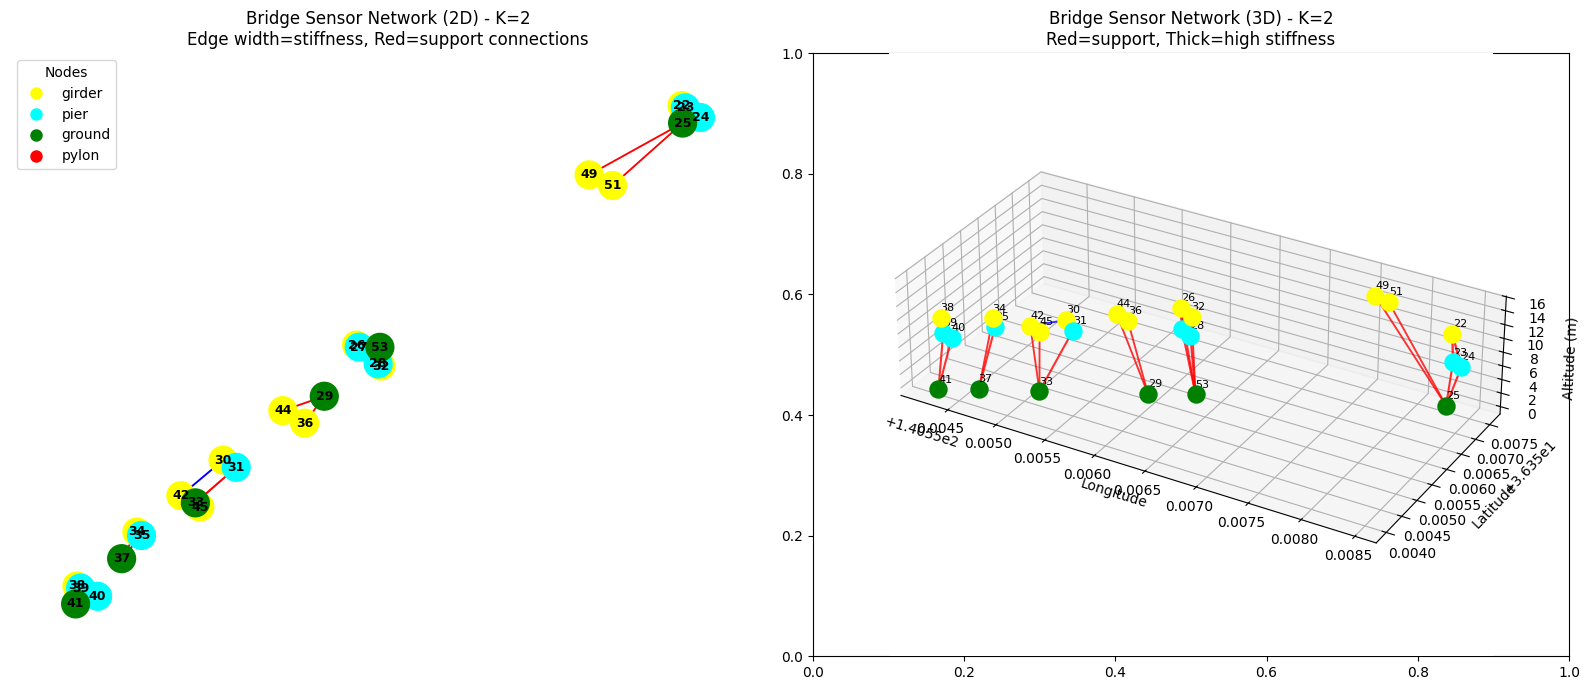


Creating edges with k=3
(Improved algorithm - with type filtering and enhanced stiffness)

Analyzing sensor positions:
Girder sensors altitude range: 9.0m - 15.0m
Pier sensors altitude range: 6.0m - 9.0m
Ground sensors altitude: 0.0m
Typical girder-pier height difference: 3.2m

Applying type filtering for k=3:
- Pier-girder connections limited to 50m (direct support)
- Ground-pier connections limited to 20m (foundation)
- Girder-girder connections limited to 150m (continuous beam)

Node 22 (girder) connects to:
  (Rejected 19 connections due to type filtering)
  1. 23 (pier) - 4.9m
  2. 24 (pier) - 15.2m
  3. 25 (ground) - 17.5m

Node 26 (girder) connects to:
  (Rejected 16 connections due to type filtering)
  1. 27 (pier) - 3.8m
  2. 53 (ground) - 18.3m
  3. 28 (pier) - 20.1m

Node 30 (girder) connects to:
  (Rejected 13 connections due to type filtering)
  1. 31 (pier) - 9.8m
  2. 42 (girder) - 38.1m
  3. 33 (ground) - 39.7m

Node 32 (girder) connects to:
  (Rejected 16 connections 

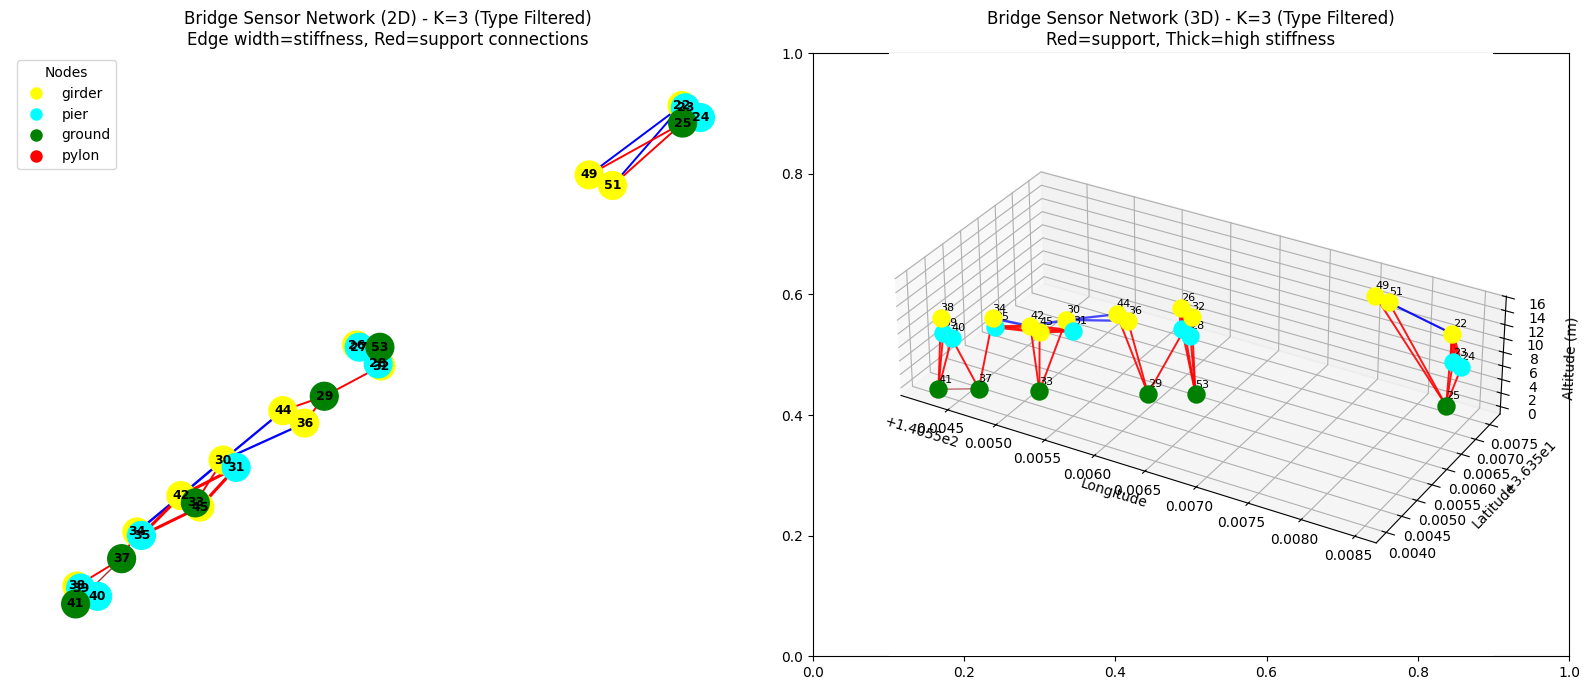


Creating edges with k=4
(Improved algorithm - with type filtering and enhanced stiffness)

Analyzing sensor positions:
Girder sensors altitude range: 9.0m - 15.0m
Pier sensors altitude range: 6.0m - 9.0m
Ground sensors altitude: 0.0m
Typical girder-pier height difference: 3.2m

Applying type filtering for k=4:
- Pier-girder connections limited to 50m (direct support)
- Ground-pier connections limited to 20m (foundation)
- Girder-girder connections limited to 150m (continuous beam)

Node 22 (girder) connects to:
  (Rejected 19 connections due to type filtering)
  1. 23 (pier) - 4.9m
  2. 24 (pier) - 15.2m
  3. 25 (ground) - 17.5m
  4. 51 (girder) - 77.0m

Node 26 (girder) connects to:
  (Rejected 16 connections due to type filtering)
  1. 27 (pier) - 3.8m
  2. 53 (ground) - 18.3m
  3. 28 (pier) - 20.1m
  4. 32 (girder) - 22.3m

Node 30 (girder) connects to:
  (Rejected 13 connections due to type filtering)
  1. 31 (pier) - 9.8m
  2. 42 (girder) - 38.1m
  3. 33 (ground) - 39.7m
  4. 45 

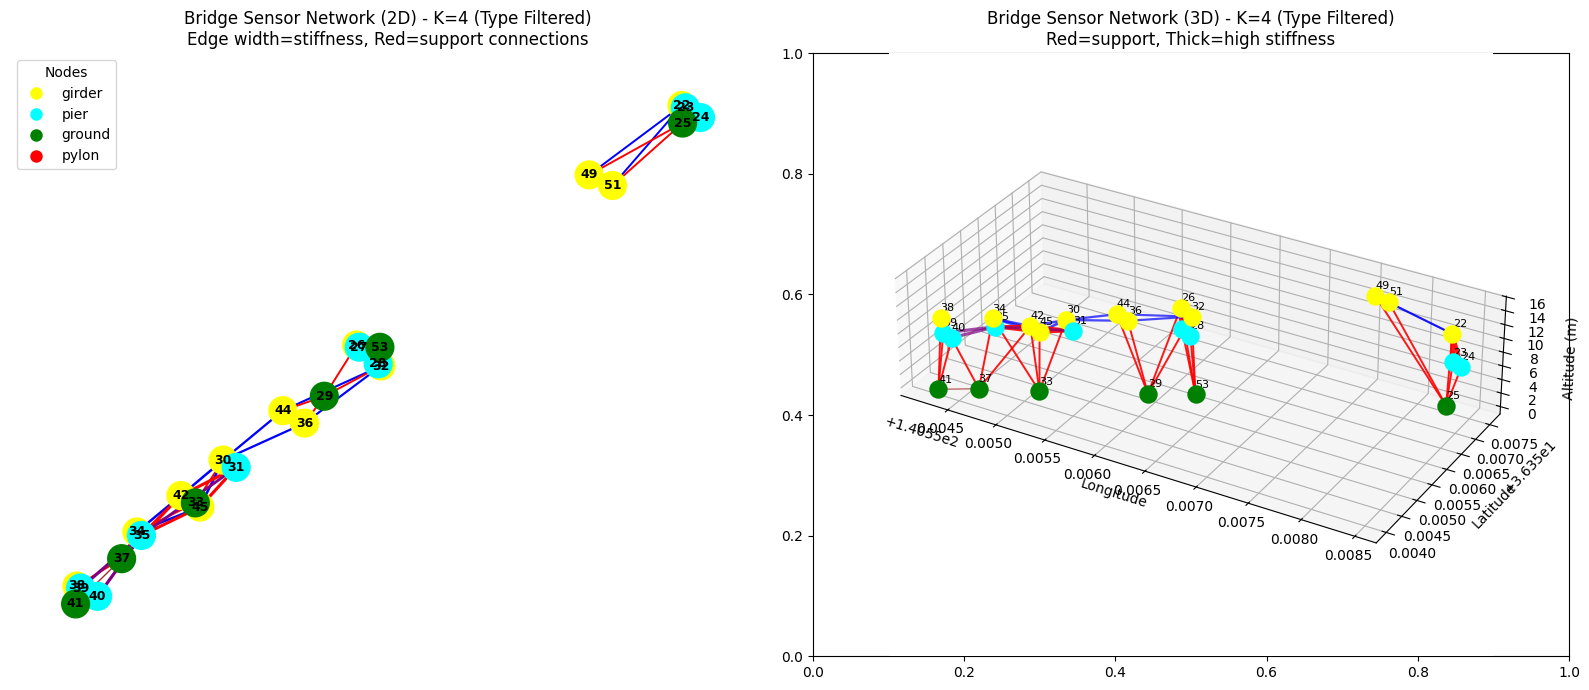


=== Analysis Complete ===
Files generated:
  - bridge_edges_k2_original.csv (unchanged)
  - bridge_edges_k3_improved.csv (with type filtering)
  - bridge_edges_k4_improved.csv (with type filtering)

Key improvements for k=3,4:
  ✓ Type filtering prevents unrealistic connections
  ✓ Enhanced stiffness values based on structural principles
  ✓ Distance limits ensure physically meaningful connections
  ✓ Better pier-girder and pylon-girder connection modeling

Recommendation: Compare k=2 vs k=3 to see filtering impact


In [19]:
if __name__ == "__main__":
    # Updated CSV data with correct altitude values
    csv_data = """node_id,type,latitude,longitude,altitude_m
22,girder,36.35760246,140.5582758,10
26,girder,36.35584565,140.5561452,12
30,girder,36.35500155,140.555271,10
32,girder,36.35569158,140.5563046,12
34,girder,36.35447425,140.5547067,10
36,girder,36.35527276,140.5558051,11
38,girder,36.35407821,140.5543137,10
42,girder,36.35474124,140.5549947,9
44,girder,36.35536433,140.5556622,11
45,girder,36.3546569,140.5551193,9
49,girder,36.35709344,140.5576679,15
51,girder,36.35701549,140.5578214,15
23,pier,36.35758548,140.5582983,6
24,pier,36.35751402,140.5583976,6
27,pier,36.35582977,140.5561624,9
28,pier,36.35570737,140.5562867,9
31,pier,36.35494837,140.5553569,9
35,pier,36.35444892,140.5547367,9
39,pier,36.35406326,140.5543382,8
40,pier,36.35400257,140.5544497,8
25,ground,36.3574735,140.5582802,0
29,ground,36.35546989,140.555934,0
33,ground,36.35468793,140.5550896,0
37,ground,36.35427857,140.5546068,0
41,ground,36.35394661,140.5543055,0
53,ground,36.35582872,140.556298,0"""

    # Load data from string
    from io import StringIO
    df = pd.read_csv(StringIO(csv_data))
    
    print("=== Improved Shin-Nakagawa Bridge Sensor Network Analysis ===")
    print("Loaded bridge sensor data:")
    print(df.head())
    print(f"\nTotal sensors: {len(df)}")
    print(f"Sensor types: {df['type'].value_counts().to_dict()}")
    
    print("\n=== Improvements for k=3,4 ===")
    print("1. Type filtering: Prevents unrealistic long-distance connections")
    print("2. Enhanced stiffness: Better structural engineering principles")
    print("3. Distance limits: Pier-girder ≤50m, Ground-pier ≤20m, etc.")
    print("4. k=2 unchanged: Original behavior preserved for comparison")
    
    # Create edges with different k values
    k_values = [2, 3, 4]
    
    for k in k_values:
        print(f"\n{'='*60}")
        print(f"Creating edges with k={k}")
        if k == 2:
            print("(Original algorithm - no type filtering)")
        else:
            print("(Improved algorithm - with type filtering and enhanced stiffness)")
        print(f"{'='*60}")
        
        edges = create_knn_edges(df, k=k)
        
        # Analyze connections
        analyze_connections(df, edges, k_value=k)
        
        # Save edges
        suffix = "_improved" if k >= 3 else "_original"
        filename = f'bridge_edges_k{k}{suffix}.csv'
        save_edges_csv(edges, filename)
        
        # Create and analyze graph
        G = create_networkx_graph(df, edges)
        analyze_graph_properties(G, k_value=k)
        
        # Visualize
        visualize_bridge_network(G, df, k_value=k)
    
    print(f"\n{'='*60}")
    print("=== Analysis Complete ===")
    print("Files generated:")
    print("  - bridge_edges_k2_original.csv (unchanged)")
    print("  - bridge_edges_k3_improved.csv (with type filtering)")
    print("  - bridge_edges_k4_improved.csv (with type filtering)")
    print("\nKey improvements for k=3,4:")
    print("  ✓ Type filtering prevents unrealistic connections")
    print("  ✓ Enhanced stiffness values based on structural principles")
    print("  ✓ Distance limits ensure physically meaningful connections")
    print("  ✓ Better pier-girder and pylon-girder connection modeling")
    print("\nRecommendation: Compare k=2 vs k=3 to see filtering impact")